In [1]:
import os 
import csv
import glob
import pandas as pd
import chardet

#read in the data frame
path = r'D:\Data Science\yelp_data_v0_1.csv'
yelp_review_df = pd.read_csv(path, encoding = 'windows-1252')

In [2]:
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

#extract just yelp rating and the reviews from primary data set
rating = yelp_review_df['Reviewer Rating Clean']
raw_reviews = yelp_review_df['Review']

#preprocessing all reviews - include only letters, lowercase letters, remove stop words and join list in para form
def review_to_words(raw_review): 
    
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review) 
    raw_words = letters_only.lower().split()
    stops = set(stopwords.words('english')) #python searching a set is faster than a list, so we convert stopwords to a set.
    meaningful_words = [w for w in raw_words if not w in stops]
    return(' '.join(meaningful_words))

clean_reviews = []
total_num_reviews = raw_reviews.shape[0]

for i in range(0, total_num_reviews):
    clean_reviews.append(review_to_words(raw_reviews[i]))
    


In [3]:
#create df with numerical ratings and good vs. bad ratings
yelp_df = pd.concat([pd.DataFrame(clean_reviews), pd.DataFrame(rating)], axis = 1)
yelp_df.columns = ['clean_reviews','rating']

#clear memory 
raw_reviews = []


gb_rating = []
for i in yelp_df.rating:
    gb_rating.append(float(1.0) if ((i == 4 or i == 5)) else float(0.0))

#create dataframe with good bad ratings where 4 or 5 is good, and others are bad 
yelp_df = pd.concat([pd.DataFrame(clean_reviews), pd.DataFrame(gb_rating)], axis = 1)
yelp_df.columns = ['clean_reviews', 'gb_rating']

#drops any rows that contain invald values
yelp_df = yelp_df[pd.notnull(yelp_df.clean_reviews)]
yelp_df = yelp_df[pd.notnull(yelp_df.gb_rating)] #ratings are currently float values


In [10]:
#first test the good bad rating data set

#create the training and test set 
from sklearn.cross_validation import train_test_split

itrain , itest = train_test_split(range(yelp_df.shape[0]), train_size = 0.7)
mask = np.zeros(yelp_df.shape[0], dtype = np.bool)
mask[itrain] = 1
mask[itest] = 0
mask = (mask == 1)

# test = yelp_df[mask]
# train = yelp_df[~mask]
# print('proportion of all restaurants having a rating of 4 or 5: %f' % np.mean(ythis))


In [11]:
#set the vectorizer to the desired parameters
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import KFold

#create functions to be called during the function calls

def make_xy(dataframe, vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(dataframe.clean_reviews)
#     X = X.toarray()
    y = (dataframe.gb_rating).values.astype(np.int)
    return X, y

def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5 
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(y[test], clf.predict(X[test])) # code modification for f1 score metric
        
#         result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

# def log_likelihood(clf, x, y):
#     prob = clf.predict_log_proba(x)
#     bad = y == 0
#     good = ~bad
#     return prob[bad, 0].sum() + prob[good, 1].sum()

In [12]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

my_vectorizer = CountVectorizer(analyzer = 'word', \
                            tokenizer = None, \
                            preprocessor = None, \
                            stop_words = None, \
                            min_df = 1e-4, 
                            ngram_range = (1,2)) 
                            #max_features = 20000)
    
Xthis, ythis = make_xy(yelp_df, my_vectorizer)

Xtrainthis = Xthis[mask]
ytrainthis = ythis[mask]
Xtestthis = Xthis[~mask]
ytestthis = ythis[~mask]

In [13]:
from scipy.sparse import identity
import itertools

words = np.array(my_vectorizer.get_feature_names())
# combined_words = np.concatenate((words,combined_df_names), axis=0)

clf = MultinomialNB(alpha = 1)
clf.fit(Xtrainthis, ytrainthis)

# x = identity(new_Xthis.shape[1])
x = identity(Xthis.shape[1])
probs = clf.predict_log_proba(x)[:, 0]

# probsnot = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

# good_words = combined_words[ind[:300]]
# bad_words = combined_words[ind[-100:]]

good_words = words[ind[:20]]
bad_words = words[ind[-20:]]

likely_good_prob = probs[ind[:20]]
likely_bad_prob = probs[ind[-20:]]


print ("Good words \t    P(good review | word)\t     P(bad review | word)")
for w, l in zip(good_words, likely_good_prob):
    print ("%20s \t \t" % w, "%0.2f \t \t" % (1 - np.exp(l)), "%0.2f" % (np.exp(l)))
    
print ("Bad words\t     P(good review | word)\t     P(bad review | word)")
for w, l in zip(bad_words, likely_bad_prob):
    print ("%20s \t \t" % w, "%0.2f \t \t" % (1 - np.exp(l)), "%0.2f" % (np.exp(l)))


Good words 	    P(good review | word)	     P(bad review | word)
          glad found 	 	 0.99 	 	 0.01
      hands favorite 	 	 0.99 	 	 0.01
delicious reasonably 	 	 0.99 	 	 0.01
      simply amazing 	 	 0.98 	 	 0.02
delicious affordable 	 	 0.98 	 	 0.02
          must visit 	 	 0.98 	 	 0.02
            try rest 	 	 0.98 	 	 0.02
        place hidden 	 	 0.98 	 	 0.02
         wait return 	 	 0.98 	 	 0.02
  amazing everything 	 	 0.98 	 	 0.02
     excellent great 	 	 0.98 	 	 0.02
      wrong anything 	 	 0.98 	 	 0.02
  recommend everyone 	 	 0.98 	 	 0.02
         cannot wait 	 	 0.98 	 	 0.02
      surprised good 	 	 0.98 	 	 0.02
    neighborhood gem 	 	 0.98 	 	 0.02
    another favorite 	 	 0.98 	 	 0.02
     delicious fresh 	 	 0.98 	 	 0.02
      definitely new 	 	 0.97 	 	 0.03
          might best 	 	 0.97 	 	 0.03
Bad words	     P(good review | word)	     P(bad review | word)
       food horrible 	 	 0.03 	 	 0.97
 huge disappointment 	 	 0.03 	 	 0.97
         asked 

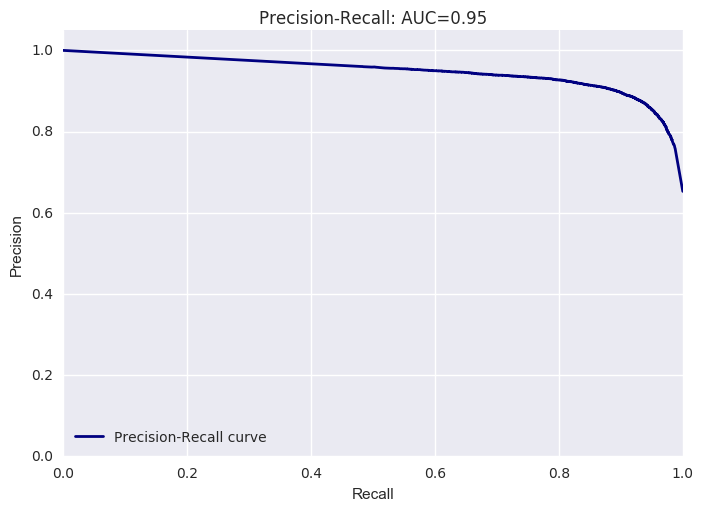

In [21]:
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report
import matplotlib.pyplot as plt 

y_predicted_score = clf.predict_proba(Xtestthis)[:,1]
precision, recall, _ = precision_recall_curve(ytestthis, y_predicted_score)
average_precision = average_precision_score(ytestthis, y_predicted_score)

plt.clf()
plt.plot(recall, precision, lw=2, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
plt.show()


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
print(Xthis.shape)
temp_score = clf.predict(Xtestthis)
target_names = ['bad review', 'good review']
print(classification_report(ytestthis, temp_score, target_names = target_names))
print (confusion_matrix(ytestthis, clf.predict(Xtestthis)))

(83349, 71510)
             precision    recall  f1-score   support

 bad review       0.84      0.77      0.80      8684
good review       0.88      0.92      0.90     16321

avg / total       0.87      0.87      0.87     25005

[[ 6730  1954]
 [ 1310 15011]]


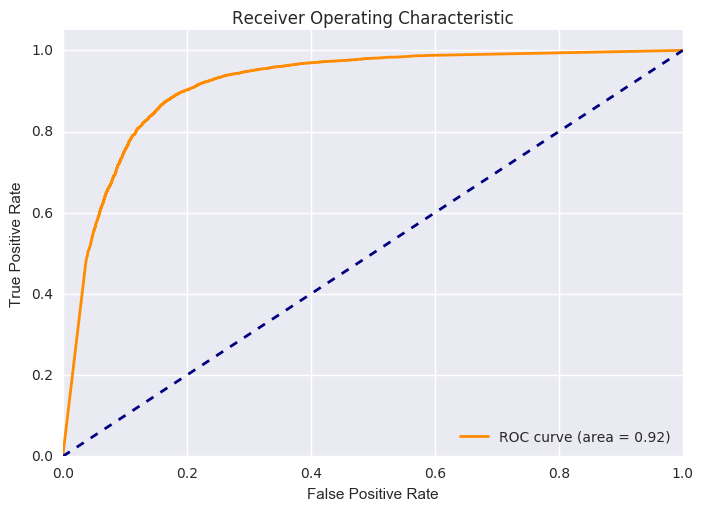

In [22]:
#create a ROC Curve
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_score = clf.predict_proba(Xtestthis)

# print(roc_auc_score(ytestthis, y_score))
#######PLOT ROC CURVE########

#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()


fpr, tpr, _ = roc_curve(ytestthis, y_score[:,1])
roc_auc = auc(fpr, tpr)

# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(ytestthis.ravel(), y_score.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [17]:
#testing uncle's restaurant data with the classifier

rating = yelp_review_df['Reviewer Rating Clean']
erawan  = yelp_review_df['Restaurant Name'] == 'Erawan Thai Cuisine'
raw_reviews = yelp_review_df['Review'] 
erawan_reviews = raw_reviews[erawan]
erawan_reviews = erawan_reviews.tolist()

#converts erawan_reviews individually to term-document 
ind_review = my_vectorizer.transform(erawan_reviews) 
ind_review_prediction = clf.predict(ind_review)

pos_percentage = np.mean(ind_review_prediction)
print('The percentage of reviews that are 4 or 5 is: {0:0.2f}'.format(pos_percentage))
print('The predicted rating for Erawan is %f' % (pos_percentage*4.5 + (1-pos_percentage)*2)) #real rating is actually a 3.4

The percentage of reviews that are 4 or 5 is: 0.60
The predicted rating for Erawan is 3.504149


In [18]:
#determining what words in the cor
from itertools import chain
from functools import reduce
import pandas as pd

#pull the probabilities for all words in the corpus
words = np.array(my_vectorizer.get_feature_names())

#identity review words that are present in the corpus
erawan_feature_frequency = ind_review.sum(axis=0) 

#intermediary step
feature_reduction = erawan_feature_frequency > 0
feature_reduction = sum(feature_reduction.tolist(), [])

keep_erawan_features = []
for index, value in enumerate(feature_reduction):
    if value == True:
        keep_erawan_features.append(index)

# reduce to only erawan features - 19000 to 2514
erawan_features = ind_review[:,keep_erawan_features] #new corpus with 2514 features occuring in Erawan reviews
erawan_words = words[keep_erawan_features]

x = identity(Xthis.shape[1])
probs = clf.predict_log_proba(x)[:, 0] #predict probability for all words in 19689 word corpus
probs = probs[keep_erawan_features] #only keep the probabilities for features that existing in erawan's corpus

#up until this point, words, features and probabilities are kept in the same order from indexing with keep_erawan_features

ind = np.argsort(probs) #return the indexes for the remaining features - these indexes were from the original corpus
#now the indexs of the re-ordered features from lowest (good) to highest(bad) are returned ranging from 0-2513

good_words = erawan_words[ind[:20]]
bad_words = erawan_words[ind[-20:]]

likely_good_prob = probs[ind[:20]]
likely_bad_prob = probs[ind[-20:]]

#filter the feature_frequency of origin corpus to restaurant corpus
feature_frequency = sum(erawan_feature_frequency.tolist(), [])
feature_frequency = [feature_frequency[i] for i in keep_erawan_features] 

    

In [19]:
#erawan's performance on each word when compared to the universe. how is the restaurant faring with the mean when it 
#comes to each feature?
erawan_ratings = rating[erawan].tolist() #pull the original ratings for erawan only

#convert those ratings to a good or bad rating, 1 or 0
erawan_gb_rating = []
for i in erawan_ratings:
    erawan_gb_rating.append(int(1) if (i == 4 or i == 5) else int(0))

erawan_local_probability = []
for feature in range(erawan_features.shape[1]): #total of 2513 features
    array = erawan_features[:,feature].toarray() #total of 241 elements in array to check
    calculate_mean = []
    for index, number in enumerate(array):
        if number > 0:
            calculate_mean.append(erawan_gb_rating[index])
    erawan_local_probability.append(np.mean(calculate_mean))

erawan_local_probability = [erawan_local_probability[i] for i in ind]
erawan_local_probability = np.around(erawan_local_probability, decimals = 2)

In [20]:
import pandas as pd
import seaborn as sns

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

new_erawan_words = [erawan_words[i] for i in ind]

erawan_word_good_prob = [1-np.exp(i) for i in probs[ind]]
erawan_word_good_prob = np.around(erawan_word_good_prob, decimals = 2)

erawan_word_bad_prob = [np.exp(i) for i in probs[ind]]
erawan_word_bad_prob = np.around(erawan_word_bad_prob, decimals = 2)

erawan_word_freq = [feature_frequency[i] for i in ind] #re-order the feature corpus per ind


erawan_df = pd.DataFrame(
    {'Word': new_erawan_words,
     'Prob Good Review': erawan_word_good_prob,
     'Prob Bad Review': erawan_word_bad_prob, 
     'Frequency of Reviews' : erawan_word_freq, 
     'Local Probability' : erawan_local_probability
    })

erawan_df = erawan_df[['Word', 'Prob Good Review', 'Prob Bad Review', 'Frequency of Reviews', 'Local Probability']]
print(erawan_df.head(20))
print(erawan_df.tail(20))

# erawan_df.to_csv(path_or_buf =  r'D:\Data Science\erawan_data.csv')

                    Word  Prob Good Review  Prob Bad Review  Frequency of Reviews  Local Probability
0             glad found              0.99             0.01                     1               1.00
1            cannot wait              0.98             0.02                     1               1.00
2   beautiful atmosphere              0.97             0.03                     1               1.00
3      equally delicious              0.97             0.03                     2               1.00
4       best restaurants              0.97             0.03                     1               1.00
5          staff amazing              0.97             0.03                     1               1.00
6              save room              0.97             0.03                     1               1.00
7         also delicious              0.96             0.04                     1               1.00
8           great casual              0.96             0.04                     1          

In [ ]:
#Grid Search Function for min_df and alpha for the Naive Bayes Classifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score

alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
ngram_range = [(1,1), (1,2), (1,3)]


#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_dfs = None
maxscore=-np.inf

for alpha in alphas:
    for min_df in min_dfs:
        for ngram in ngram_range:

            vectorizer = CountVectorizer(min_df= min_df, ngram_range = ngram)
            Xthis, ythis = make_xy(yelp_df, vectorizer)

            #train set
            Xtrainthis = Xthis[mask]
            ytrainthis = ythis[mask]

            clf = MultinomialNB(alpha = alpha)
            cvscore = cv_score(clf, Xtrainthis, ytrainthis, f1_score)

            if cvscore > maxscore:
                maxscore = cvscore
                best_alpha, best_min_df, best_ngram = alpha, min_df, ngram

print('alpha: {}'.format(best_alpha))
print('min_df: {}'.format(best_df))
print('best_ngram: {}'.format(best_ngram))

# best values are alpha = 1, min_df = .0001, ngram = 1,2


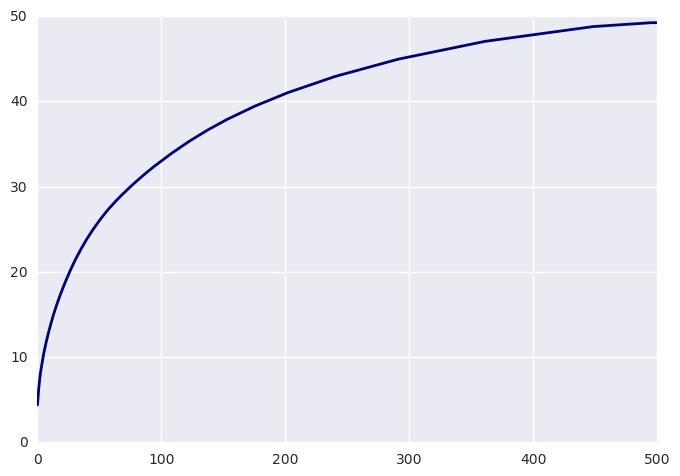

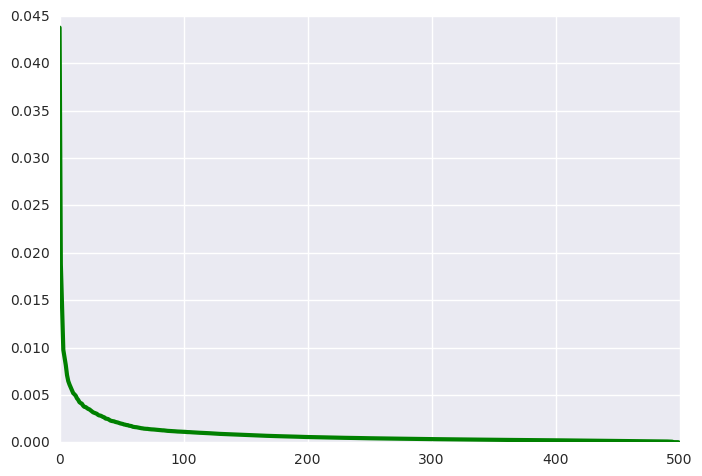

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [33]:
#experiment: attempt at truncated PCA
from sklearn.decomposition import TruncatedSVD 
from sklearn.utils.extmath import randomized_svd #the same as Truncated SVD
import matplotlib.pyplot as plt

# Xtrainthis = new_Xthis[mask]
# ytrainthis = ythis[mask]
# Xtestthis = new_Xthis[~mask]
# ytestthis = ythis[~mask]

Xtrainthis = Xthis[mask]
ytrainthis = ythis[mask]
Xtestthis = Xthis[~mask]
ytestthis = ythis[~mask]

svd = TruncatedSVD(n_components = 500, algorithm = 'randomized', n_iter = 10, random_state = 42) 
U, Sigma, VT = randomized_svd(Xtrainthis, n_components = 500, n_iter = 5, random_state = 42)

#says for LSA n_components should b between 100-500

svd.fit(Xtrainthis, ytrainthis)
var = svd.explained_variance_ratio_

var1 = np.cumsum(np.round(svd.explained_variance_ratio_, decimals = 4)*100)

plt.plot(var1, lw=2, color='navy')
plt.show()
plt.plot(var, lw=3, color = 'green')
plt.show()

clf.fit(Xtrainthis,ytrainthis)




In [ ]:
#experiment: add meta data features to the review data

import ast
import itertools
import math
import re
from scipy.sparse import csr_matrix, hstack, vstack
from sklearn.feature_extraction import DictVectorizer

path = r'D:\Data Science\yelp_metadata_v0_1.csv'
yelp_meta_df = pd.read_csv(path, encoding = 'windows-1252')
dictionary_1 = {}
expected_cost = yelp_meta_df['Expected Cost'].fillna('n')


#create features for the dollar range
zero_dollars = []
one_dollars = []
two_dollars = []
three_dollars = []

for value in expected_cost:
    zero_dollars.append(1 if (len(value) == 0) else 0)
    one_dollars.append(1 if (len(value) == 1) else 0)
    two_dollars.append(1 if (len(value) == 2) else 0)
    three_dollars .append(1 if (len(value) == 1) else 0)

dictionary_1['zero dollars'] = zero_dollars
dictionary_1['one dollars'] = one_dollars
dictionary_1['two dollars'] = two_dollars
dictionary_1['three dollars'] = three_dollars
dictionary_1.pop('zero dollars')

#create features for the cuisine
cuisines = yelp_meta_df['Cuisines']
cuisine_list = [ast.literal_eval(x) for x in cuisines]
list_cuisine = itertools.chain.from_iterable(cuisine_list)
mylist = list(set(list_cuisine))


#initialize dictionary and then create empty dictionaries
dictionary = {}
for cuisine in mylist:
    dictionary.setdefault(cuisine, [])

# for each_cuisine in temp_dict:
for review in cuisine_list:
    for cuisine_type in review:
        dictionary[cuisine_type].append(1)
        
    temp_list = set(mylist) - set(review) #create a remainder list of values
    
    for cuisine_type in temp_list:
        dictionary[cuisine_type].append(0)


#create features for alcohol
dictionary_2 = {}
alcohol = yelp_meta_df['Alcohol'].fillna('Missing_1')
unique_alcohol_list = set(alcohol)

for alcohol_status in unique_alcohol_list:
    dictionary_2.setdefault(alcohol_status, [])

for index, value in enumerate(alcohol):
    if value  == 'Full Bar':
        temp_list = unique_alcohol_list - set([value])
        dictionary_2['Full Bar'].append(1)
        for value in temp_list:
            dictionary_2[value].append(0)
               
    elif value  == 'Missing_1':
        temp_list = unique_alcohol_list - set([value])
        dictionary_2['Missing_1'].append(1)
        for value in temp_list:
            dictionary_2[value].append(0)
        
    elif value  == 'Beer & Wine Only':
        temp_list = unique_alcohol_list - set([value])
        dictionary_2['Beer & Wine Only'].append(1)
        for value in temp_list:
            dictionary_2[value].append(0)
        
    elif value  == 'No':
        temp_list = unique_alcohol_list - set([value])
        dictionary_2['No'].append(1)
        for value in temp_list:
            dictionary_2[value].append(0)
        
dictionary_2['No Alcohol'] = dictionary_2.pop('No')

#create features for ambience
dictionary_3 = {}
ambience = yelp_meta_df['Ambience'].fillna('Missing_2')
unique_ambience_list = set(['Casual', 'Trendy', 'Hipster', 'Divey', 'Romantic', 'Classy', 'Intimate', 'Missing_2'])

for ambience_type in unique_ambience_list:
    dictionary_3.setdefault(ambience_type, [])

for index, value in enumerate(ambience):
    temp_list = unique_ambience_list #initialize a temporary list
    for ambience_type in unique_ambience_list:
        if re.search(ambience_type, value) != None:
            p = re.search(ambience_type, value).group(0)  
            dictionary_3[p].append(1)
            temp_list = temp_list - set([p])
    for remaining_ambience in temp_list:
        dictionary_3[remaining_ambience].append(0)
dictionary_3.pop('Missing_2')
        
#create features for Good for Groups
dictionary_4 = {}
g4g = yelp_meta_df['Good for Groups'].fillna('Missing_3')

dictionary_4.setdefault('Good for Group', [])

for index, value in enumerate(g4g):
    if value  == 'Yes':
        dictionary_4['Good for Group'].append(1)
    else:
        dictionary_4['Good for Group'].append(0)
             
#create features for Noise Level
dictionary_5 = {}
noise_level = yelp_meta_df['Noise Level'].fillna('Missing_4')
noise_level_list = set(noise_level)

for noise_type in noise_level_list:
    dictionary_5.setdefault(noise_type, [])

for noise_type in noise_level:
    temp_list = noise_level_list - set([noise_type]) #create a remainder list of values
    dictionary_5[noise_type].append(1)
    for other_noise_type in temp_list:
        dictionary_5[other_noise_type].append(0)
dictionary_5.pop('Missing_4')

combined_dict = {**dictionary_1, **dictionary_2, **dictionary_3, **dictionary_4, **dictionary_5}

#compiling meta feature names and adding the meta tag at the end
combined_df_names = np.array(pd.DataFrame(combined_dict).columns.values)
for index, value in enumerate(combined_df_names):
    combined_df_names[index] += '_meta'

combined_df_values = csr_matrix(pd.DataFrame(combined_dict))

review_rest_name = yelp_review_df['Restaurant Name']
meta_rest_name = yelp_meta_df['Restaurant Name']

empty_sparse_matrix = csr_matrix((83349, 19))
for review_index, review in enumerate(review_rest_name):
    for meta_index, meta in enumerate(meta_rest_name):
        if review == meta:
            empty_sparse_matrix[review_index, :] = combined_df_values[meta_index, :]

#combine Xthis and meta-data matrix 
new_Xthis = hstack([Xthis, empty_sparse_matrix], format = 'csr')